___
## Ciência dos Dados - PROJETO 3 - INSPER

___
### Feito por: Theo Barbara, Abel Cavalcante, Gustavo Pierre e Victor Jurdi
___

# Wines Review

___

## A. INTRODUÇÃO

Para o Projeto 3 de Ciências dos Dados, o grupo escolheu trabalhar com vinhos. O nosso DataSet contém 10 variavéis(Pais de origem, descrição do vinho, designação, pontos na avaliação, preço, provincia, região, variedade e a adega produtora) e temos como objetivo procurar prever o preço do vinho através das variavéis mais qualificadas, que serão, o país, os pontos (nota do vinho) e o tipo da uva.

___
## B. MINERANDO DADOS e CARACTERÍSTICAS DO DATASET

### BASE DE DADOS

Em primeira instância, as bibliotecas foram importadas e os dadeos foram filtrados:

In [73]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from operator import itemgetter
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [74]:
x=pd.read_csv('winemag-data_first150k.csv')
del x["Unnamed: 0"]
x.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


Após isso, foi criado uma nova coluna com a frequência relativa dos tipos de uva. isso é feito pois, como há diversos vinhos extremamente raros, acabariam não fazendo tanta  relevância na nossa análise. Assim, os vinhos com frequência menor que 0.5% foram deletados do dataset.

In [75]:
dic = {}
dic2 = {}
lista = []
lista2=[]
i=0

for e in x.variety:
    if e not in dic:
        dic[e] = 1
    elif e in dic:
        dic[e] +=1

for e in dic:
    if dic[e] > 0:
        lista.append(dic[e]/len(dic))
        
for e in x.variety:
    if e not in dic2:
        dic2[e] = 1

for e in dic2:
    dic2[e] = lista[i]
    i+=1
    
for uva in x.variety:
    lista2.append(dic2[uva])
    
x["Frequencia"] = lista2
novo_x = x[x.Frequencia>0.5]

novo_x.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery,Frequencia
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,20.253165
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,10.000000
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,22.612342
8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström,22.612342
9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm,22.612342


Por fim, criamos 

In [76]:
novo_x.loc[(novo_x.price<50),'Preço'] = 'Até 50'
novo_x.loc[(novo_x.price>50)&(novo_x.price<=200),'Preço'] = 'Até 200'
novo_x.loc[(novo_x.price>200)&(novo_x.price<=400),'Preço'] = 'Até 400'
novo_x.loc[(novo_x.price>400)&(novo_x.price<=600),'Preço'] = 'Até 600'
novo_x.loc[(novo_x.price>600)&(novo_x.price<=800),'Preço'] = 'Até 800'
novo_x.loc[(novo_x.price>800)&(novo_x.price<=1000),'Preço'] = 'Até 1000'
novo_x.loc[(novo_x.price>1000)&(novo_x.price<=1500),'Preço'] = 'Até 1500'
novo_x.loc[(novo_x.price>2000),'Preço'] = 'Mais que 2000'

novo_x.loc[(novo_x.points<=80),'Pontos'] = '80 pontos'
novo_x.loc[(novo_x.points>80)&(novo_x.points<=85),'Pontos'] = '81 - 85 pontos'
novo_x.loc[(novo_x.points>85)&(novo_x.points<=90),'Pontos'] = '86 - 90 pontos'
novo_x.loc[(novo_x.points>90)&(novo_x.points<=95),'Pontos'] = '91 - 95 pontos'
novo_x.loc[(novo_x.points>95)&(novo_x.points<=100),'Pontos'] = '95 - 100 pontos'

novo_x.head()

C:\Users\gppie\OneDrive\Documentos\INSPER\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\gppie\OneDrive\Documentos\INSPER\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,country,description,designation,points,price,province,region_1,region_2,variety,winery,Frequencia,Preço,Pontos
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,20.253165,Até 400,95 - 100 pontos
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,10.000000,Até 200,95 - 100 pontos
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,22.612342,Até 200,95 - 100 pontos
8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström,22.612342,Até 200,91 - 95 pontos
9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm,22.612342,Até 200,91 - 95 pontos


### ANÁLISE DESCRITIVA

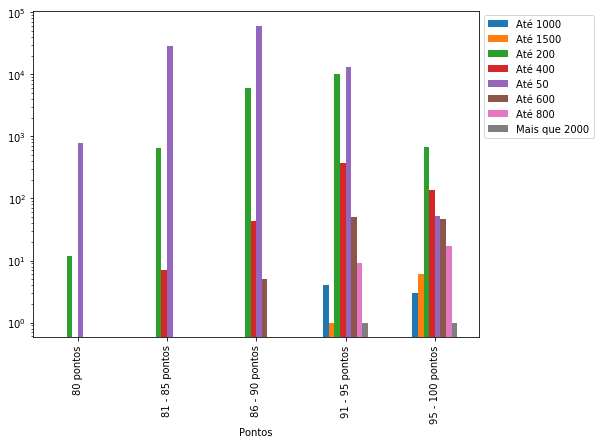

In [77]:
data = pd.crosstab(novo_x.Pontos, novo_x.Preço)
data.plot(kind='bar', figsize=(8,6));
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.8));

In [78]:
novo_x.points.corr(novo_x.price)

0.4600421512441059

In [79]:
novo_x.Frequencia.corr(novo_x.price)

0.11149984361374775

In [80]:
novo_x.Frequencia.corr(novo_x.points)

0.06969229048694064

In [81]:
#plt.hist(novo_x["country"]);

In [82]:
#plt.hist(novo_x["Preço"]);

In [83]:
#plt.hist(novo_x.Pontos);

In [84]:
#plt.figure(figsize = (10, 10))
#sns.heatmap(novo_x.corr(), linewidth=0.5)
#plt.show()

In [85]:
dummy = pd.get_dummies(novo_x['variety'])
dummy.head()

,Aglianico,Albariño,Barbera,Bordeaux-style Red Blend,Bordeaux-style White Blend,Cabernet Franc,Cabernet Sauvignon,Carmenère,Champagne Blend,Chardonnay,...,Sauvignon Blanc,Shiraz,Sparkling Blend,Syrah,Tempranillo,Tempranillo Blend,Torrontés,Viognier,White Blend,Zinfandel
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
novo_x = pd.concat([novo_x,dummy],axis=1)
novo_x.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery,...,Sauvignon Blanc,Shiraz,Sparkling Blend,Syrah,Tempranillo,Tempranillo Blend,Torrontés,Viognier,White Blend,Zinfandel
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,...,0,0,0,0,0,0,0,0,0,0
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,...,1,0,0,0,0,0,0,0,0,0
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,...,0,0,0,0,0,0,0,0,0,0
8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström,...,0,0,0,0,0,0,0,0,0,0
9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm,...,0,0,0,0,0,0,0,0,0,0


In [87]:
dummy2 = pd.get_dummies(novo_x['country'])
dummy2.head()

,Argentina,Australia,Austria,Brazil,Bulgaria,Canada,Chile,China,Croatia,Cyprus,...,Slovenia,South Africa,Spain,Switzerland,Tunisia,Turkey,US,US-France,Ukraine,Uruguay
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [88]:
novo_x = pd.concat([novo_x,dummy2],axis=1)
novo_x.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery,...,Slovenia,South Africa,Spain,Switzerland,Tunisia,Turkey,US,US-France,Ukraine,Uruguay
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,...,0,0,0,0,0,0,1,0,0,0
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,...,0,0,0,0,0,0,1,0,0,0
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,...,0,0,0,0,0,0,1,0,0,0
8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström,...,0,0,0,0,0,0,1,0,0,0
9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm,...,0,0,0,0,0,0,1,0,0,0


In [89]:
novo_x = novo_x.dropna(subset=['price'])
del novo_x['description']
del novo_x['designation']
del novo_x['province']
del novo_x['region_1']
del novo_x['region_2']
del novo_x['variety']
del novo_x['winery']
del novo_x['country']

In [115]:
novo_x.columns

Index(['points', 'price', 'Aglianico', 'Albariño', 'Barbera',
       'Bordeaux-style Red Blend', 'Bordeaux-style White Blend',
       'Cabernet Franc', 'Cabernet Sauvignon', 'Carmenère', 'Champagne Blend',
       'Chardonnay', 'Chenin Blanc', 'Corvina, Rondinella, Molinara',
       'Dolcetto', 'Gamay', 'Garganega', 'Garnacha', 'Gewürztraminer', 'Glera',
       'Grenache', 'Grüner Veltliner', 'Malbec', 'Meritage', 'Merlot',
       'Montepulciano', 'Moscato', 'Nebbiolo', 'Nero d'Avola', 'Petite Sirah',
       'Pinot Blanc', 'Pinot Grigio', 'Pinot Gris', 'Pinot Noir', 'Port',
       'Portuguese Red', 'Portuguese White', 'Prosecco', 'Red Blend',
       'Rhône-style Red Blend', 'Rhône-style White Blend', 'Riesling', 'Rosé',
       'Sangiovese', 'Sangiovese Grosso', 'Sauvignon Blanc', 'Shiraz',
       'Sparkling Blend', 'Syrah', 'Tempranillo', 'Tempranillo Blend',
       'Torrontés', 'Viognier', 'White Blend', 'Zinfandel', 'Argentina',
       'Australia', 'Austria', 'Brazil', 'Bulgaria', 'Ca

In [103]:
#para dividir em test e train
del novo_x['Preço']
del novo_x['Pontos']
del novo_x['Frequencia']

In [104]:
seed = 569

X_train, X_test, y_train, y_test = train_test_split(novo_x, novo_x.price, random_state = seed)


___
## C. MODELOS DE PREDIÇÃO

o MODELO DE PREDIÇÃO PELA MÉDIA (Sem uso de variável explicativa).

In [105]:
#seed = 569

#X_train, X_test, y_train, y_test = train_test_split(novo_x, novo_x.price, random_state = seed)


media_price = np.mean(X_train.price)
print('O preço predito foi ${0}'.format(media_price))


O preço predito foi $33.77181114368242


In [106]:
z=0
for e in y_train:

    r= (e - media_price)**2
    z+=r
z
    
RMS_train=(z/len(y_train))**(1/2)

b=0
for e in y_test:

    rm= (e - media_price)**2
    b+=rm
b


RMS_test = (b/len(y_test))**(1/2)

print(RMS_train)
print(RMS_test)

36.58151231903599
38.2570032785192


![title](img/003c2e0e-26b4-4e73-8cea-6182eda838b2.png)

RMS_train = 36.58

RMS_test = 38.25


Nesse modelo fi = ȳ, portanto

R²=0

o MODELO DOS K VIZINHOS MAIS PRÓXIMOS (K-Nearest Neighbors Regression)

In [114]:
erro = []
for k in range(1,5):
    clf = KNeighborsRegressor(k)
    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    erro.append(mean_squared_error(y_test,y_pred_test))



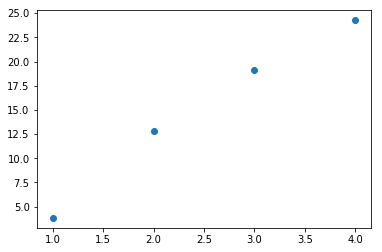

In [116]:
lista = [1,2,3,4]
plt.scatter(lista, erro)

In [118]:
clf = KNeighborsRegressor(3)
clf.fit(X_train, y_train)
print(mean_squared_error(y_test,y_pred_test))

24.25070466771897


o MODELO DE REGRESSÃO LINEAR (Multiple Linear Regression)

In [97]:
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D

In [98]:
def regress(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

In [107]:
X = X_train

In [108]:
Y = y_train

In [109]:
results3 = regress(X, Y)
results3.summary()

C:\Users\gppie\OneDrive\Documentos\INSPER\lib\site-packages\statsmodels\base\model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\gppie\OneDrive\Documentos\INSPER\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\gppie\OneDrive\Documentos\INSPER\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\gppie\OneDrive\Documentos\INSPER\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.319e+32
Date:                Tue, 28 May 2019   Prob (F-statistic):               0.00
Time:                        23:42:59   Log-Likelihood:             2.6816e+06
No. Observations:               93129   AIC:                        -5.363e+06
Df Residuals:                   93034   BIC:                        -5.362e+06
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          -3.57e-13   3.78e-14     -9.445      0.000   -4.31e-13   -2.83e-13
points                         3.941e-15   8.95e-17     44.047      0.000    3.77e-15    4.12e-15
price                             1.0000   7.95e-18   1.26e+17      0.000       1.000       1.000
Aglianico                     -1.421e-14   5.47e-15     -2.596      0.009   -2.49e-14   -3.48e-15
Albariño                      -2.948e-14   4.06e-15     -7.268      0.000   -3.74e-14   -2.15e-14
Barbera                       -1.249e-14   2.91e-15     -4.295      0.000   -1.82e-14   -6.79e-15
Bordeaux-style Red Blend      -4.829e-15   1.62e-15     -2.981      0.003      -8e-15   -1.65e-15
Bordeaux-style White Blend     4.663e-15   3.74e-15      1.246      0.213   -2.67e-15     1.2e-14
Cabernet Franc                 1.721e-15   2.53e-15      0.680      0.497   -3.24e-15    6.68e-15
Cabernet Sauvignon            -6.162e-15   1.22e-15     -5.041      0.000   -8.56e-15   -3.77e-15
Carmenère                     -9.992e-15   3.49e-15     -2.864      0.004   -1.68e-14   -3.15e-15
Champagne Blend                -1.79e-14   2.97e-15     -6.018      0.000   -2.37e-14   -1.21e-14
Chardonnay                      1.11e-16   1.18e-15      0.094      0.925    -2.2e-15    2.43e-15
Chenin Blanc                    4.33e-15   3.56e-15      1.215      0.224   -2.65e-15    1.13e-14
Corvina, Rondinella, Molinara -8.549e-15   2.69e-15     -3.179      0.001   -1.38e-14   -3.28e-15
Dolcetto                        4.53e-14   4.95e-15      9.145      0.000    3.56e-14     5.5e-14
Gamay                         -1.976e-14   5.22e-15     -3.789      0.000      -3e-14   -9.54e-15
Garganega                      4.996e-15   4.98e-15      1.004      0.315   -4.75e-15    1.47e-14
Garnacha                       4.441e-16   4.61e-15      0.096      0.923   -8.59e-15    9.48e-15
Gewürztraminer                -7.994e-15   3.05e-15     -2.624      0.009    -1.4e-14   -2.02e-15
Glera                         -1.055e-14   4.08e-15     -2.585      0.010   -1.85e-14   -2.55e-15
Grenache                      -2.998e-15   3.65e-15     -0.821      0.411   -1.01e-14    4.15e-15
Grüner Veltliner              -6.661e-16   4.03e-15     -0.165      0.869   -8.57e-15    7.24e-15
Malbec                        -5.329e-15   2.07e-15     -2.568      0.010    -9.4e-15   -1.26e-15
Meritage                      -1.854e-14   4.85e-15     -3.824      0.000    -2.8e-14   -9.04e-15
Merlot                        -3.997e-15   1.52e-15     -2.630      0.009   -6.98e-15   -1.02e-15
Montepulciano                 -1.882e-14   5.23e-15     -3.596      0.000   -2.91e-14   -8.56e-15
Moscato                       -2.442e-15   4.44e-15     -0.550      0.582   -1.11e-14    6.26e-15
Nebbiolo                       -9.77e-15   2.

o MODELO DE ÁRVORES DE REGRESSÃO (Decision Tree Regression)

In [110]:
from sklearn.tree import DecisionTreeRegressor

In [129]:
regressor = DecisionTreeRegressor(random_state = seed)
regressor.fit(X_train, y_train)

y_pred_test2 = regressor.predict(X_test)
y_pred_train2=regressor.predict(X_train)

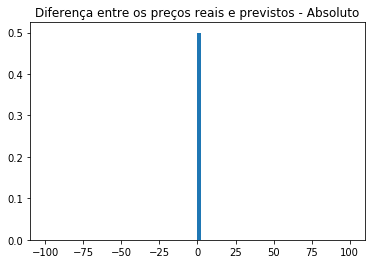

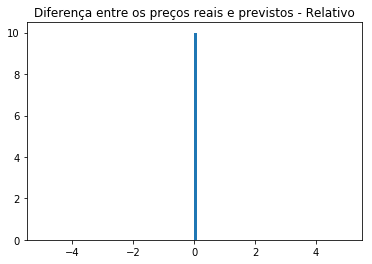

In [131]:
y_test_final=[]
for a in y_test.values:
    y_test_final.append(a)

y_test_final=np.array(y_test_final)
dif_abs = y_pred_test2 - y_test_final
dif_rel = (y_pred_test2 - y_test_final)/y_test_final

plt.hist(dif_abs, density = True, bins= 100, range=(-100,100));
plt.title("Diferença entre os preços reais e previstos - Absoluto")
plt.show();

plt.hist(dif_rel, density = True, bins= 100, range=(-5,5))
plt.title("Diferença entre os preços reais e previstos - Relativo")
plt.show();

___
## D. PROCESSO E ESTATÍSTICAS DE VALIDAÇÃO


![title](img/003c2e0e-26b4-4e73-8cea-6182eda838b2.png)

[Esse item depende dos resultados das modelagens anteriores! Organize-os aqui de forma clara!]

o MODELO DE PREDIÇÃO PELA MÉDIA

##### Feito abaixo do modelo!

o MODELO DOS K VIZINHOS MAIS PRÓXIMOS (K-Nearest Neighbors Regression)

In [144]:
t=0
for e in y_train:
    
    rr=(e - y_pred_train)**2
    t+=rr
    
RMS_train =(t/len(y_train))**(1/2)

s=0
for e in y_test:
    
    re=(e - y_pred_test)**2
    s+=re
    
RMS_test0 =(s/len(y_test))**(1/2)

print(RMS_train)
print(RMS_test0)


media_price = np.mean(X_train.price)

z=0
for e in y_train:

    r= (e - media_price)**2
    z+=r
    
r2=t/z

print(r2)

[38.26590217 36.60212414 40.66994363 ... 39.08797546 43.62689593
 39.83662976]
[40.86506639 42.99253783 43.45791239 ... 41.70926504 42.99253783
 64.06167099]
[1.09420981 1.00112722 1.23601525 ... 1.14172903 1.4222807  1.18588306]


In [145]:
#RMS_train 

print("RMS test =",np.mean(RMS_test0))


#R²=

RMS test = 45.21626920506579


o MODELO DE REGRESSÃO LINEAR (Multiple Linear Regression)

In [138]:
v=0
for e in y_train:
    
    rr=(e - y_pred_train1)**2
    v+=rr
    
RMS_train =(t/len(y_train))**(1/2)

d=0
for e in y_test:
    
    re=(e - y_pred_test1)**2
    d+=re
    
RMS_test =(s/len(y_train))**(1/2)

print(RMS_train)
print(RMS_test)


media_price = np.mean(X_train.price)

k=0
for e in y_train:

    r= (e - media_price)**2
    k+=r
    
r2=v/k

print(r2)

TypeError: 'numpy.ndarray' object is not callable

RMS_train = 

RMS_test = 


R²=

o MODELO DE ÁRVORES DE REGRESSÃO (Decision Tree Regression)

In [146]:
f=0
for e in y_train:
    
    rr=(e - y_pred_train2)**2
    f+=rr
    
RMS_train =(t/len(y_train))**(1/2)

g=0
for e in y_test:
    
    re=(e - y_pred_test2)**2
    g+=re
    
RMS_test2 =(s/len(y_train))**(1/2)

print(RMS_train)
print(RMS_test2)


media_price = np.mean(X_train.price)

k=0
for e in y_train:

    r= (e - media_price)**2
    k+=r
    
r2=f/k

print(r2)

[38.26590217 36.60212414 40.66994363 ... 39.08797546 43.62689593
 39.83662976]
[23.59345708 24.82175329 25.09043742 ... 24.0808554  24.82175329
 36.98602299]
[1.09420981 1.00112722 1.23601525 ... 1.14172903 1.4222807  1.18588306]


In [147]:
#RMS_train = 

print("RMS_test = ",np.mean(RMS_test2))


#R²=

RMS_test =  26.10562519729533


___
## E. CONCLUSÃO

___
## F. REFERÊNCIAS BIBLIOGRÁFICAS

https://ensinandomaquinasblog.wordpress.com/2017/12/15/modelos-preditivos-de-notas-de-redacao-do-enem-2015/

https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f